# Retrieval Augmented Generation

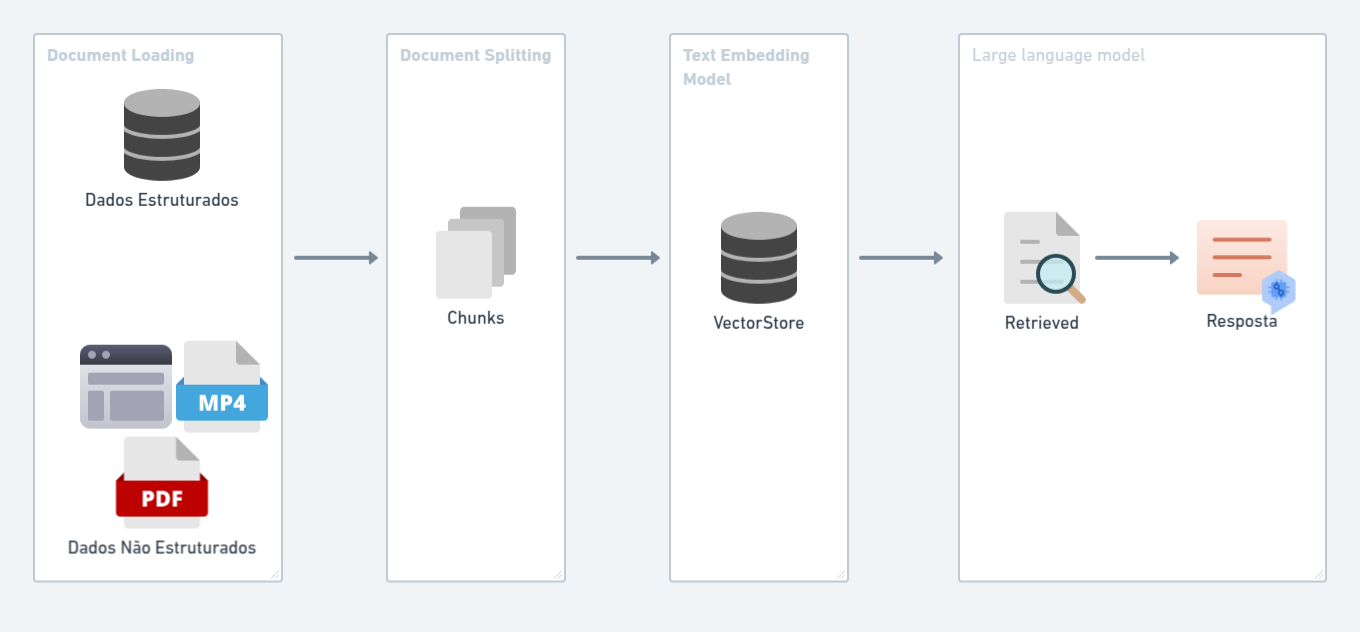


O **RAG** combina recuperação de informações com modelos de geração de linguagem para criar respostas contextualizadas e precisas. O pipeline se divide em cinco etapas:

1. **Carregamento de Documentos**: Dados estruturados (bancos de dados) e não estruturados (PDFs, vídeos) são carregados como fonte de conhecimento.

2. **Divisão de Documentos**: Os textos são divididos em **chunks** menores para facilitar a indexação e processamento.

3. **Modelo de Embedding**: Cada chunk é convertido em vetores numéricos, que capturam o significado semântico do texto. Ferramentas como **OpenAIEmbeddings** e **GoogleEmbeddings** podem ser usadas.

4. **VectorStore e Recuperação**: Os vetores são armazenados em sistemas como **FAISS** ou **Chroma**. A busca é feita com técnicas como **Semantic Search** e **MMR**, garantindo relevância e diversidade.

5. **Geração de Resposta**: Um **Large Language Model (LLM)** utiliza os fragmentos recuperados para gerar respostas precisas e contextualizadas.

Essa abordagem torna o RAG ideal para sistemas como assistentes virtuais, motores de busca e ferramentas de suporte ao cliente.

# **1. Document Loading (Carregamento de Documentos)**

Nesta etapa, os dados são carregados de diferentes fontes. Esses dados podem ser:

- **Estruturados:** Bases de dados, planilhas ou qualquer formato que já segue um esquema definido.
- **Não Estruturados:** Arquivos como PDFs, vídeos (MP4), sites, e documentos de texto que exigem processamento adicional para extração de conteúdo.

O objetivo desta fase é reunir as informações necessárias que alimentarão o sistema.

## Carregando PDFs

In [5]:
from langchain_community.document_loaders.pdf import PyPDFLoader

caminho = './arquivos/ppc.pdf' 
loader = PyPDFLoader(caminho)
documentos = loader.load()

In [ ]:
len(documentos)

In [ ]:
print(documentos[0].page_content)

In [ ]:
documentos[0].metadata

### Fazendo perguntas para o arquivo

In [24]:
from langchain.chains.question_answering import load_qa_chain
from langchain_openai.chat_models import ChatOpenAI

chat = ChatOpenAI(model='gpt-3.5-turbo-0125')

chain = load_qa_chain(llm=chat, chain_type='stuff', verbose=False)

In [ ]:
pergunta = 'Quais assuntos são tratados no documento?'

chain.run(input_documents=documentos[40:50], question=pergunta)

## Carregando csv

In [11]:
from langchain_community.document_loaders.csv_loader import CSVLoader

caminho = 'arquivos/Top 1000 IMDB movies.csv'
loader = CSVLoader(caminho)
documentos = loader.load()

In [12]:
import os
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
# Set cache to save results to memory
from langchain_google_genai import ChatGoogleGenerativeAI
# Carregar as variáveis do arquivo .env
load_dotenv()

# Obter as chaves das APIs
gemini_api_key = os.getenv("GOOGLE_API_KEY")


# Correctly initialize the ChatGoogleGenerativeAI model
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=gemini_api_key, top_p=0.30)

In [ ]:
from langchain.chains.question_answering import load_qa_chain
from langchain_openai.chat_models import ChatOpenAI


chain = load_qa_chain(llm=llm, chain_type='stuff', verbose=True)

pergunta = 'Qual é o filme com maior metascore?'
chain.run(input_documents=documentos[:10], question=pergunta)

## Carregando da Internet

O erro HTTP Error 403: Forbidden no yt-dlp geralmente significa que o site bloqueou a requisição, seja por falta de autenticação, restrições regionais ou mudanças no método de acesso.

solução (Atualizar o yt-dlp): pip install -U yt-dlp


In [ ]:
import os
import subprocess

from langchain_community.document_loaders.generic import GenericLoader
from langchain_community.document_loaders.blob_loaders import FileSystemBlobLoader
from langchain.document_loaders.parsers import OpenAIWhisperParser

# Cria o diretório de destino, se não existir
save_dir = 'docs/youtube'
os.makedirs(save_dir, exist_ok=True)

# URL do vídeo do YouTube
url = 'https://www.youtube.com/watch?v=_IxHzJWXP_M'

# Comando para baixar e extrair o áudio em formato mp3 usando yt-dlp
# O parâmetro -o define o caminho/filename sem extensão; yt-dlp adicionará a extensão apropriada.
command = [
    "yt-dlp", "-x", "--audio-format", "mp3",
    "-o", os.path.join(save_dir, "audio.%(ext)s"),
    url
]

# Executa o comando e verifica se ocorreu algum erro
subprocess.run(command, check=True)

# Caminho para o arquivo de áudio baixado 
audio_file_path = os.path.join(save_dir, "audio.mp3")

# Instancia o loader para o arquivo local
loader = GenericLoader(
    FileSystemBlobLoader(audio_file_path),
    OpenAIWhisperParser()
)

# Carrega o documento (a transcrição)
docs = loader.load()

# Exibe o conteúdo transcrito
for doc in docs:
    print(doc.page_content)


# **2. Document Splitting (Divisão de Documentos)**




O **Retrieval Augmented Generation (RAG)** é uma abordagem que integra técnicas de recuperação de informações com a geração de linguagem natural, permitindo que modelos de IA forneçam respostas mais precisas e contextualizadas. Um dos componentes essenciais nesse fluxo é o **document splitting**, ou divisão de texto, que segmenta documentos extensos em fragmentos menores e mais manejáveis. Essa prática é fundamental para melhorar a eficiência na indexação, na recuperação e no processamento de informações.

O objetivo principal ao dividir documentos em partes menores é garantir que um modelo de linguagem (LLM) receba apenas os trechos mais relevantes para uma determinada consulta. No entanto, surge a seguinte questão:

> **Como podemos segmentar o texto sem comprometer a integridade da informação?**

Vamos analisar um exemplo. Suponha que temos o seguinte trecho:




Agora, imagine que essa informação seja dividida incorretamente da seguinte maneira:

- `"O novo modelo da Renault é"`
- `"o Duster, possui 110"`
- `"cavalos de potência e"`
- `"um preço estimado de"`
- `"180 mil reais."`

Nesse caso, cada fragmento isolado perde seu significado completo, tornando-se menos útil para processamento ou análise. Isso mostra a importância de uma segmentação bem estruturada, evitando cortes que prejudiquem o contexto da informação.

---


Utilizar os parâmetros de overlap já auxiliam para minimizar este tipo de problema:

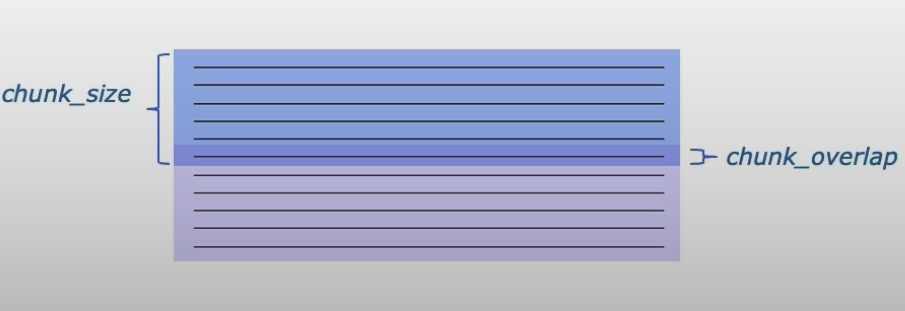

Dessa forma, mantemos parte dos dados do trecho anterior no trecho seguinte, evitando saltos bruscos de conteúdo entre as partes.

No contexto de **RAG (Retrieval-Augmented Generation)**, o pré-processamento de texto é crucial para garantir que os documentos sejam divididos em chunks (pedaços) semanticamente coerentes. Dois métodos populares no LangChain são:

## 1. **CharacterTextSplitter**
Divide o texto em chunks baseando-se em um **caractere específico** (como espaços, quebras de linha, etc.). O `CharacterTextSplitter` é uma abordagem simples para segmentação de textos baseada em um número fixo de caracteres. Essa técnica realiza a divisão sem levar em conta a estrutura semântica ou gramatical do conteúdo, resultando em fragmentos com tamanho uniforme.

### **Quando Usar?**
- Textos simples sem estrutura hierárquica clara.
- Quando você quer controle total sobre o separador.

In [ ]:
from langchain.text_splitter import CharacterTextSplitter

text = '''
Já conhece a lista em Python? Quer entender como manipular listas e quais são suas principais utilidades e métodos? Sabe qual a diferença entre listas e tuplas? Este artigo responde responde isso e muito mais! Aproveite ao máximo todo o potencial dessa estrutura de dados essencial para a programação em Python.

A lista em Python é uma das estruturas de dados fundamentais da linguagem Python. Além de possuir grande versatilidade, as listas são extremamente relevantes para iniciantes na programação, por incorporar uma variedade de conceitos básicos de Python como mutabilidade, indexação, iteração e slicing. Mas você já conhece as listas de Python a fundo?

Neste artigo, vamos nos aprofundar nas listas em Python e aprender a utilizá-las em seus códigos. Ao longo do texto, você aprenderá como criar e manipular uma lista em Python, quais os principais métodos de listas, e como elas se relacionam e com outros tipos de dados de Python, como strings, tuplas e vetores. Vamos lá!

'''
# Configuração
splitter = CharacterTextSplitter(
    separator=".",  # Separador padrão: quebras de linha
    chunk_size=50,   # Tamanho máximo de cada chunk (em caracteres)
    chunk_overlap=20  # Sobreposição entre chunks
)

# Split
chunks = splitter.split_text(text)
chunks

### **Parâmetros Principais**:
| Parâmetro         | Descrição                                  |
|-------------------|--------------------------------------------|
| `separator`       | Caractere usado para dividir o texto.      |
| `chunk_size`      | Tamanho máximo de cada chunk.              |
| `chunk_overlap`   | Sobreposição entre chunks para manter contexto. |


## RecursiveCharacterTextSplitter

O `RecursiveCharacterTextSplitter` adota uma abordagem mais sofisticada para a divisão de textos. Em vez de simplesmente cortar o texto em intervalos fixos, ele utiliza uma estratégia recursiva que busca preservar a estrutura semântica, utilizando delimitadores naturais como quebras de parágrafo, de linha, ou até espaços.

### Características

- **Preservação da Coerência Semântica**: Ao identificar pontos naturais de divisão, os fragmentos mantêm uma coesão interna melhor.
- **Flexibilidade**: Permite definir múltiplos delimitadores e ajustar os níveis de granularidade conforme a necessidade.
- **Compromisso entre Performance e Qualidade**: Embora a análise seja mais complexa e possa exigir mais recursos computacionais, o resultado tende a ser mais relevante para tarefas que dependem da compreensão do conteúdo.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter


# Configuração
splitter = RecursiveCharacterTextSplitter(
    chunk_size=50,   # Tamanho máximo (em caracteres)
    chunk_overlap=10,
    separators=["\n\n", "\n", ". ", " ", ""]  # Ordem de prioridade
)

# Split
chunks = splitter.split_text(text)
chunks

### **Vantagens**:
- Mantém a estrutura lógica do texto.
- Adapta-se melhor a documentos complexos.

# 3. **Text Embedding Model (Modelo de Embedding)**

Nesta etapa, cada **chunk** é transformado em um vetor numérico por meio de um **modelo de embeddings**, como o **OpenAIEmbeddings** ou **GoogleGenerativeAIEmbeddings**. Esses vetores capturam as características semânticas dos textos, permitindo comparações com base no significado, em vez de palavras-chave.

---

## 1. **OpenAIEmbeddings**
Embeddings gerados pelos modelos da OpenAI. O serviço não é gratuito
### **Quando Usar?**
- Alta precisão em buscas semânticas.
- Quando custo por requisição não é um fator crítico.
- Projetos que já utilizam outros serviços da OpenAI (ex: GPT-4).


In [20]:
from langchain_openai import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model='text-embedding-ada-002')

In [ ]:
embedings = embedding_model.embed_documents(
    [
        'Eu gosto de cochorros',
        'Eu gosto de animais',
        'O tempo está ruim lá fora'
    ]
)

In [ ]:
for emb in embedings:
    print(len(emb), max(emb), min(emb))

In [ ]:
embedings[0][:10]

In [ ]:
import numpy as np
for i in range(len(embedings)):
    for j in range(len(embedings)):
        print(round(np.dot(embedings[i], embedings[j]), 2), end=' | ')
    print()

## GoogleGenerativeAIEmbeddings

O **GoogleGenerativeAIEmbeddings** é uma alternativa que aproveita os recursos dos modelos generativos da Google para criar embeddings robustos e precisos. Essa solução integra-se bem com o ecossistema Google, oferecendo vantagens para desenvolvedores que já utilizam outras ferramentas da empresa.

### Características Principais

- **Precisão Avançada:** Utiliza tecnologia generativa para captar detalhes semânticos complexos e sutis.
- **Integração com o Ecossistema Google:** Facilita a conexão com outros serviços e ferramentas, ampliando as possibilidades de aplicação.
- **Eficiência na Recuperação:** Produz embeddings altamente eficazes para sistemas de recuperação, contribuindo para respostas mais relevantes em contextos RAG.


In [23]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",
)

embedings = embedding_model.embed_documents(
    [
        'Eu gosto de cochorros',
        'Eu gosto de animais',
        'O tempo está ruim lá fora'
    ]
)

In [ ]:
import numpy as np
for i in range(len(embedings)):
    for j in range(len(embedings)):
        print(round(np.dot(embedings[i], embedings[j]), 2), end=' | ')
    print()

### versão alternativa

In [ ]:
import google.generativeai as genai
from dotenv import load_dotenv
import os
# Configure sua API Key
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

# Modelo para embeddings (se disponível)
# Nota: Até julho/2024, o Gemini não tem um endpoint dedicado para embeddings.
documentos = [
        'Eu gosto de cochorros',
        'Eu gosto de animais',
        'O tempo está ruim lá fora'
    ]
# Função para embedding de consulta (usada para busca)
def embed_query(query):
    response = genai.embed_content(
        model="models/text-embedding-004",
        content=query,
        task_type="RETRIEVAL_QUERY"  # Tipo para queries
    )
    return response['embedding']
# Função para gerar embeddings
def embed_documents(texts):
    embeddings = []
    for text in texts:
        response = genai.embed_content(
            model="models/text-embedding-004",
            content=text,
            task_type="RETRIEVAL_DOCUMENT"
        )
        embeddings.append(response['embedding'])
    return embeddings

# Gerar embeddings
embeddings = embed_documents(documentos)

# Exibir
for doc, emb in zip(documentos, embeddings):
    print(f"Documento: {doc}\nEmbedding (exemplo): {emb[:3]}...\n")

# **4. VectorStore (Armazenamento)**

No framework de **Retrieval Augmented Generation (RAG)**, os **VectorStores** são componentes essenciais para indexar e recuperar embeddings de forma eficiente. Esses sistemas armazenam as representações vetoriais dos documentos, permitindo que o mecanismo de busca encontre rapidamente os fragmentos de texto mais relevantes para uma consulta.

link: https://python.langchain.com/docs/integrations/vectorstores/

## Importância dos VectorStores

- **Indexação Eficiente:** Armazenam embeddings de documentos para buscas rápidas.
- **Recuperação de Similaridade:** Permitem a identificação dos vetores mais próximos semanticamente à consulta.
- **Integração com RAG:** Facilitam a conexão entre a etapa de recuperação e a geração de respostas, aumentando a relevância e o contexto da informação fornecida.

Dois dos bancos de dados vetoriais mais populares são:


## Chroma

**Chroma** é uma solução moderna de VectorStore que se destaca pela facilidade de integração com pipelines de NLP e RAG. Ele oferece uma interface simples e escalável, ideal para desenvolvedores que desejam uma implementação rápida sem sacrificar a performance.


### Características do Chroma

- **Interface Intuitiva:** Fácil configuração e utilização.
- **Escalabilidade:** Suporta o armazenamento de grandes volumes de embeddings.
- **Integração:** Compatível com diversas ferramentas e frameworks de NLP, facilitando a incorporação em projetos RAG.

In [29]:
from langchain_community.document_loaders.pdf import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings

### Document Laoding
caminho = "arquivos/ppc.pdf"
loader = PyPDFLoader(caminho)
paginas = loader.load()

### Text Splitting
recur_split = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    separators=["\n\n", "\n", ".", " ", ""]
)

documents = recur_split.split_documents(paginas)

### Embeddings
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001"
)

### Ambiente linux

In [ ]:
!pip install pysqlite3-binary

In [68]:
 __import__('pysqlite3')
 import sys
 sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

### Exemplo de uso

In [30]:
from langchain_chroma import Chroma

diretorio = 'arquivos/chroma_vectorstore_gemini' ## opcional. Pode salvar em memória
vectorstore = Chroma.from_documents(
                     documents=documents,                 # Data
                     embedding=embedding_model,    # Embedding model
                     persist_directory=diretorio # Directory to save data
                     )

In [ ]:
# Busca semântica
results = vectorstore.similarity_search("Inteligência Artificial", k=3)
results

## FAISS

**FAISS** (Facebook AI Similarity Search) é uma biblioteca desenvolvida pelo Facebook para a busca eficiente de vetores em larga escala. É amplamente utilizada em aplicações que exigem alta performance na recuperação de embeddings, especialmente quando se lida com bases de dados massivas.

### Características do FAISS

- **Alta Performance:** Otimizado para realizar buscas de similaridade de forma extremamente rápida.
- **Escalabilidade:** Capaz de lidar com milhões de vetores, mantendo a eficiência.
- **Flexibilidade:** Suporta diversas métricas de similaridade e pode ser customizado conforme as necessidades do projeto.

In [33]:
from langchain_community.vectorstores.faiss import FAISS

vectorstore = FAISS.from_documents(
    documents=documents,
    embedding=embedding_model
)

In [ ]:
# Busca semântica
results = vectorstore.similarity_search("Inteligência Artificial", k=3)
for doc in results:
    print(doc.page_content)
    print(f'====== {doc.metadata}\n\n')

### Salvando bd FAISS

In [36]:
vectorstore.save_local('arquivos/faiss_bd')

### Importando bd FAISS

In [ ]:
from langchain_community.vectorstores.faiss import FAISS

vectorstore = FAISS.load_local(
    'arquivos/faiss_bd',
    embeddings=embedding_model,
    allow_dangerous_deserialization=True
)

## Comparação Detalhada
| Característica          | **Chroma**                                  | **FAISS**                                  |
|-------------------------|---------------------------------------------|--------------------------------------------|
| **Facilidade de Uso**   | ✅ Integração simples com LangChain.        | ⚠️ Requer configuração manual do índice.   |
| **Escalabilidade**      | Adequado para até ~100k documentos.        | Ideal para >1M documentos.                |
| **Persistência**        | Automática (via `persist_directory`).      | Manual (métodos `save_local`/`load_local`).|
| **Velocidade**          | Rápido para cargas pequenas/médias.        | Extremamente rápido em grandes datasets.  |
| **GPU Support**         | ❌ Não suportado.                           | ✅ Suporta aceleração por GPU.             |
| **Idiomas**             | Suporte multilíngue via embeddings.        | Independente de idioma (trabalha com vetores). |

# **5. Retrieval** 

No estágio de **Retrieval** do RAG, o objetivo é recuperar os documentos mais relevantes para alimentar o modelo gerador. Duas estratégias comuns são:

---

## 1. **Semantic Search (Busca Semântica)**
Recupera documentos com base na **similaridade de cosseno** entre o embedding da consulta e os embeddings dos documentos.

### **Quando Usar?**
- Consultas diretas com respostas objetivas.
- Quando a redundância nos resultados não é crítica.
- Prototipagem rápida.


```python
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# Configuração
embeddings = OpenAIEmbeddings()
vector_store = Chroma.from_texts(texts, embeddings)

# Busca semântica padrão
results = vector_store.similarity_search("Qual a capital do Brasil?", k=3)
```


### **Vantagens**:
- Simplicidade de implementação.
- Baixo custo computacional.

### **Limitações**:
- Pode retornar documentos redundantes.
- Não considera diversidade nos resultados.

---

## 2. **MMR (Maximal Marginal Relevance)**
Combina **relevância** e **diversidade**, selecionando documentos que são simultaneamente relevantes para a consulta e diferentes entre si.

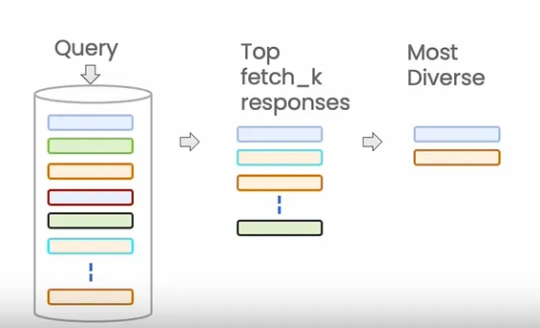

### **Quando Usar?**
- Consultas complexas que exigem múltiplas perspectivas.
- Para evitar redundância em resultados (ex: sumarização de documentos).
- Quando a diversidade de contextos é crítica.


In [39]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores.chroma import Chroma

caminhos = [
    "arquivos/ppc.pdf",
    "arquivos/disciplinas.pdf"
    ]

paginas = []

for caminho in caminhos:
    loader = PyPDFLoader(caminho)
    paginas.extend(loader.load())

recur_split = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    separators=["\n\n", "\n", ".", " ", ""]
)

documents = recur_split.split_documents(paginas)

### Embeddings
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001"
)

### Modificando metadata (boa prática)
for i, doc in enumerate(documents):
    doc.metadata['source'] = doc.metadata['source'].replace('arquivos/', '')
    doc.metadata['doc_id'] = i

### Vectorstore
diretorio = 'arquivos/chroma_retrival_bd' ## opcional. Pode salvar em memória
vectorstore = Chroma.from_documents(
                     documents=documents,                 # Data
                     embedding=embedding_model,    # Embedding model
                     persist_directory=diretorio # Directory to save data
                     )

In [ ]:
pergunta = 'Qual é a ementa de Inteligência Artificial?'

docs = vectorstore.max_marginal_relevance_search(pergunta, k=3, fetch_k=10)
for doc in docs:
    print(doc.page_content)
    print(f'==========={doc.metadata}\n\n')

### **Parâmetros Principais**:
| Parâmetro       | Descrição                                   |
|-----------------|---------------------------------------------|
| `lambda_mult`   | Controla o trade-off entre relevância e diversidade. |
| `fetch_k`       | Número de documentos candidatos para filtrar (padrão: 20). |

## Comparação Detalhada
| Característica          | **Semantic Search**                        | **MMR**                                   |
|-------------------------|--------------------------------------------|-------------------------------------------|
| **Foco**                | Relevância pura                            | Relevância + Diversidade                 |
| **Caso de Uso Ideal**   | Perguntas factuais ("Quem descobriu o Brasil?") | Perguntas exploratórias ("Quais são os desafios da sustentabilidade?") |
| **Redundância**         | Alta                                       | Baixa                                     |
| **Parâmetros Chave**    | `k` (número de resultados)                 | `lambda_mult`, `fetch_k`                 |
| **Custo Computacional** | Baixo                                      | Moderado (depende de `fetch_k`)          |

---

## Melhores Práticas para RAG
1. **Ajuste o `lambda_mult`**:
   - Valores próximos a **0.5-0.7** geralmente oferecem um bom equilíbrio.
   - Teste empiricamente com seu dataset.

2. **Controle o `fetch_k`**:
   - Defina `fetch_k` maior que `k` para permitir diversidade (ex: `fetch_k=50`, `k=5`).

3. **Combine com Filtros**:
   - Use metadados (ex: data, fonte) para pré-filtrar documentos antes do MMR.

# Combinar RAG com modelo de linguagem (LLM)

# RetrievalQA 

O **RetrievalQA** é um componente fundamental no framework de **Retrieval Augmented Generation (RAG)**. Ele combina a recuperação de informações relevantes (retrieval) com um modelo de geração de linguagem (LLM), criando um sistema de perguntas e respostas robusto e eficiente.

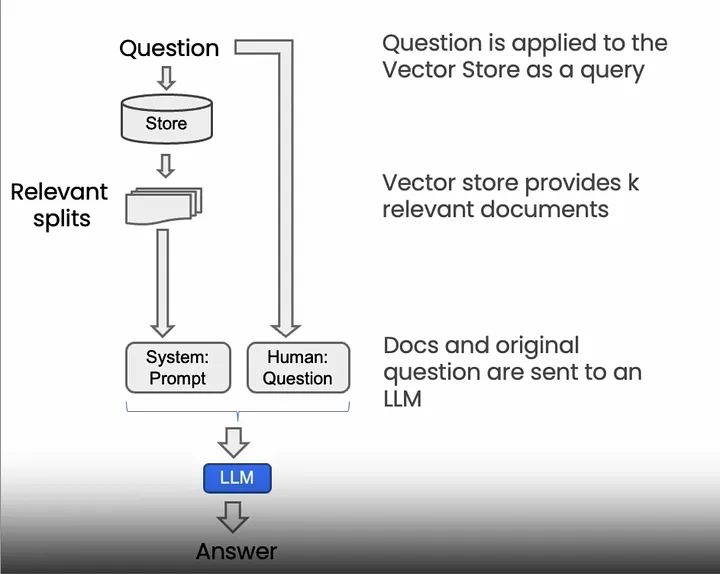

## Como Funciona o RetrievalQA

O RetrievalQA opera em quatro etapas principais:

1. **Consulta do Usuário**: O usuário insere uma pergunta ou consulta.
2. **Recuperação de Informações**: O sistema busca os documentos mais relevantes em um **VectorStore**, utilizando técnicas como **Semantic Search** ou **MMR** para garantir relevância e diversidade.
3. **Geração de Resposta**: Um **Large Language Model (LLM)** utiliza os documentos recuperados como contexto para gerar uma resposta completa e precisa.
4. **Apresentação da Resposta**: A resposta final é apresentada ao usuário, com base nas informações encontradas.

## Características do RetrievalQA

- **Contextualização Precisa**: Garante que as respostas sejam baseadas em dados específicos da base de conhecimento.
- **Flexibilidade de Integração**: Pode ser usado com diferentes tipos de dados e sistemas de armazenamento, como **Chroma** e **FAISS**.
- **Escalabilidade**: Suporta grandes volumes de dados e consultas complexas.


## Vantagens do RetrievalQA

- **Respostas Diretas**: Gera respostas claras com base em informações relevantes.
- **Adaptação a Diferentes Contextos**: Útil em aplicações como suporte ao cliente, FAQs e assistentes virtuais.
- **Melhor Experiência de Usuário**: Reduz a necessidade de navegação manual em grandes bases de dados.



In [1]:
from langchain_community.vectorstores.chroma import Chroma
from langchain_community.document_loaders.pdf import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

caminhos = [
    "arquivos/ppc.pdf",
    "arquivos/disciplinas.pdf"
    ]

paginas = []

for caminho in caminhos:
    loader = PyPDFLoader(caminho)
    paginas.extend(loader.load())

recur_split = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=10,
    separators=["\n\n", "\n", ".", " ", ""]
)

documents = recur_split.split_documents(paginas)

### Embeddings
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001"
)

### Modificando metadata (boa prática)
for i, doc in enumerate(documents):
    doc.metadata['source'] = doc.metadata['source'].replace('arquivos/', '')
    doc.metadata['doc_id'] = i

### Vectorstore
diretorio = 'arquivos/chroma_retrival_bd'

vectorstore = Chroma.from_documents(
                     documents=documents,                 # Data
                     embedding=embedding_model,    # Embedding model
                     persist_directory=diretorio # Directory to save data
                     )


In [2]:
from langchain_community.chat_models import ChatMaritalk
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts.chat import ChatPromptTemplate
from dotenv import load_dotenv
import os

load_dotenv()  # Carrega a chave do .env


llm = ChatMaritalk(
    model="sabia-3",  # Available models: sabia-3
    api_key=os.getenv("MARITALK_API_KEY"),  # Insert your API key here
    temperature=0.7,
    max_tokens=100,
)

In [3]:
from langchain.chains.retrieval_qa.base import RetrievalQA

chat_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=vectorstore.as_retriever(search_type='mmr',chain_type='stuff')
)

In [ ]:
from langchain.globals import set_debug

pergunta = 'Quais as disciplinas do 4º Semestre?'
#pergunta = 'Qual é a ementa de Inteligência Artificial?'
#pergunta = 'Qual a carga horária total do curso de bacharelado sistema de informação ?'
#pergunta = 'Quais CARACTERÍSTICAS GERAIS DO CURSO de sistemas de informação ?'
pergunta = 'Qual quantidade de vagas no CURSO de sistemas de informação ?'
set_debug(False)

chat_chain.invoke({'query': pergunta})

#USANDO MAP CUSTA 4 MINUTOS DE TEMPO
#com modeo do google tive respostas erradas em grande parte
#com modeo do maritalk tive respostas corretas em grande parte


# Técnicas de Combinação em RetrievalQA: Stuff, Map-Reduce e Refine

No **RetrievalQA**, após recuperar os documentos relevantes, o próximo passo é combiná-los para gerar uma resposta. Dependendo do volume de dados e da complexidade da consulta, diferentes estratégias podem ser usadas para integrar o conteúdo recuperado com o modelo de linguagem. As três abordagens mais comuns são: **Stuff**, **Map-Reduce** e **Refine**.

---

## **1. Stuff**

A abordagem **Stuff** simplesmente concatena todos os documentos recuperados em um único texto e o passa como entrada para o modelo de linguagem (LLM). Essa é a técnica mais direta e simples, ideal para cenários com um pequeno número de documentos ou textos curtos.

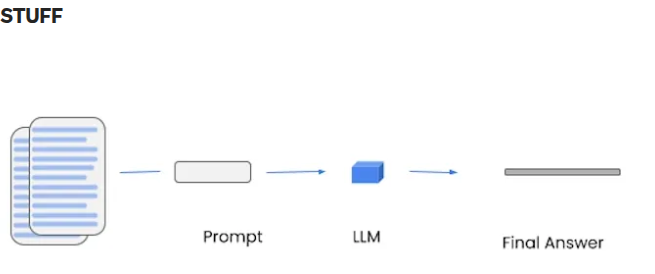


### Características:
- **Vantagem:** É rápida e eficiente.
- **Limitação:** Não é adequada para grandes volumes de texto, pois o modelo pode atingir o limite de tokens.
- **Quando Usar:** Quando a consulta envolve poucos documentos e o contexto pode ser processado integralmente.

### Fluxo:
1. Todos os documentos recuperados são concatenados.
2. O texto resultante é enviado ao modelo para geração da resposta.

### Exemplo de Código:
```python
from langchain.chains import RetrievalQA

qa = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="stuff")
response = qa.run("Pergunta do usuário")
print(response)
```

---

## **2. Map-Reduce**

A abordagem **Map-Reduce** divide o processo em duas etapas principais:
1. **Map:** Cada documento recuperado é processado separadamente pelo modelo para gerar respostas individuais.
2. **Reduce:** As respostas individuais são combinadas ou resumidas em uma única resposta final.

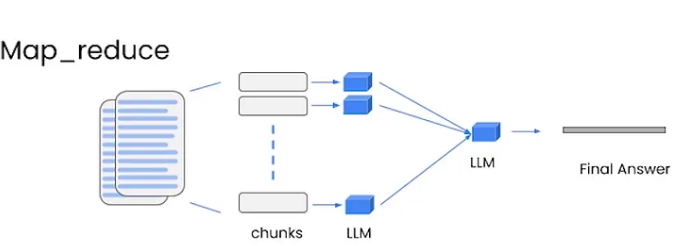

### Características:
- **Vantagem:** Escalável para grandes volumes de documentos.
- **Limitação:** Mais lenta, pois processa cada documento separadamente.
- **Quando Usar:** Quando há muitos documentos ou quando é necessário garantir que todos os documentos sejam considerados.

### Fluxo:
1. O modelo processa cada documento individualmente para gerar respostas preliminares (map).
2. As respostas preliminares são combinadas em uma única resposta (reduce).

### Exemplo de Código:
```python
qa = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="map_reduce")
response = qa.run("Pergunta do usuário")
print(response)
```

---

## **3. Refine**

A abordagem **Refine** é iterativa, onde a resposta inicial é gerada a partir de um documento, e cada documento subsequente é usado para refinar essa resposta.

<img src="images\refine.png" width="500" >

### Características:
- **Vantagem:** Gera respostas altamente contextualizadas, incorporando informações progressivamente.
- **Limitação:** Mais demorada, pois refina a resposta em várias etapas.
- **Quando Usar:** Quando a precisão é prioritária ou quando os documentos contêm informações complementares.

### Fluxo:
1. A resposta inicial é gerada com base no primeiro documento.
2. Cada documento seguinte é usado para atualizar ou melhorar a resposta inicial.

### Exemplo de Código:
```python
qa = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="refine")
response = qa.run("Pergunta do usuário")
print(response)
```

---

## Comparação das Abordagens

| Aspecto         | **Stuff**                  | **Map-Reduce**               | **Refine**                   |
|------------------|----------------------------|------------------------------|------------------------------|
| **Complexidade** | Baixa                     | Moderada                     | Alta                        |
| **Eficiência**   | Alta                      | Média                        | Baixa                       |
| **Precisão**     | Média (se poucos dados)   | Alta                         | Muito Alta                  |
| **Uso Ideal**    | Poucos documentos curtos  | Muitos documentos            | Documentos complementares   |

